<a href="https://colab.research.google.com/github/sandrinjoy/micrograd-learnings/blob/main/2_Value_in_NN_%2C_Backpropagation%2C_Optimizing_NN_micrograd_tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will be looking into how a value/variable is defined in a NN.

A value in NN can become very complex unlike prev examples of derivatives we looked it.

So, we create a class definition for Value.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [3]:
class Value:
  def __init__(self, data, _children= (), _op = '', label=''):
    self.data= data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out
a = Value(3, label='a')
b = Value(5, label = 'b')
c = Value(8, label = 'c')
e = a*b
e.label = 'e'
d = e+c
d.label = 'd'
d.data, d._prev, d._op

f = Value(-2.0, label = 'f')
L = d *f
L.label = 'L'

To visualize, we will be using a graphviz

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

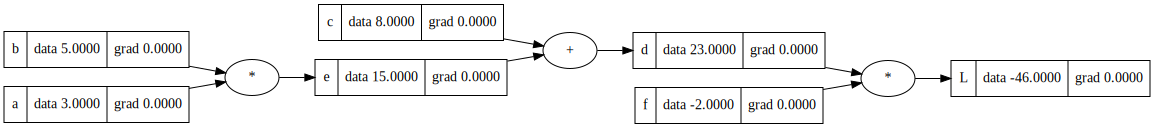

In [5]:
draw_dot(L)

Here, L is the loss function

next, we will be finding the derivates of all the leaf nodes, which will become the weight of NN

So rather than relying on the data value , we will reply on a value, we call it Gradiant value.

gradiant = derivative of L (output) wrt values (a, b, c, d,e f)

grad -> 0 , means no effect




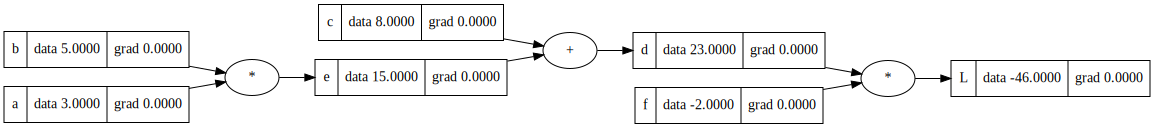

In [6]:
draw_dot(L)

In [12]:
def mock():
  h= 0.0001

  a = Value(3, label='a')
  b = Value(5, label = 'b')
  c = Value(8, label = 'c')
  e = a*b
  e.label = 'e'
  d = e+c
  d.label = 'd'
  d.data, d._prev, d._op
  f = Value(-2.0, label = 'f')
  L = d *f
  L.label = 'L'
  L1 = L.data

  a = Value(3 + h, label='a')
  b = Value(5, label = 'b')
  c = Value(8, label = 'c')
  e = a*b
  e.label = 'e'
  d = e+c
  d.label = 'd'
  d.data, d._prev, d._op
  f = Value(-2.0+h, label = 'f')
  L = d *f
  L.label = 'L'
  L2 = L.data

  print((L2 -L1)/h)
mock()

13.000499999975546


###Manual backpropagation by finding derivatives


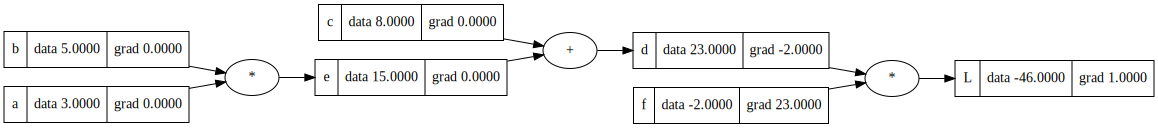

In [14]:
# result grad is 1 , base case  (l2 -l1)/h
L.grad = 1
draw_dot(L)

d & f , derivatives

L = d * f

dL/dd = f  because,

(f(x+h) - f(x))/h

substitute x with d

((d+h)*f - d*f)/h

(df+ + hf - df )/h

=> hf/h => f


therefore
dL/dd = f
dF/dL = d (opposite)

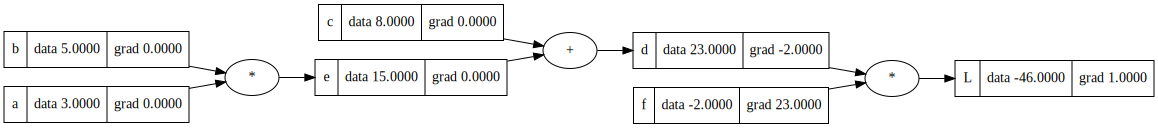

In [11]:
# grad of f will be d & grad of d will be d

f.grad = 23.0
d.grad = -2.0
draw_dot(L)

### Crux of Backpropagation

#### The Important gradient to understand (c, e)

#### By understanding this, You will understand most of the backprogatation and the training of Neural Nets :)
we need to find the gradient of c & e wrt to L

 - so we already know how d & f wrt L

 - and we can similarily find c & e wrt d

So somehow if we can link these 2, then we can find how  c &e wrt L

 # dL/dc



#### Step 1 : dd/dc & dd/de

1) d.d/dc

d = c + e

=> d. (c + e)/dc

  solving:

    (f(x+h) -f(x) )/h
    => c+e +h  - (c+e) /h
    => c+e+h -c -e /h
    =>  h/h
    => 1

=> 1.0

ie, d.d/dc = 1.0

llly,
2) d.c/de  = 1.0


### We can call these as local derivatives

 #### Step 2 : Chain Rule in calcus

 now we know, dl/dd, dd/dc, dd/de

 by chain rule in calculus

 ## dz/dx =  dz/dy * dy/dx

 a car travels 4 times faster than a cycle

 cycle travels 2 times faster than a walking man

 then : car travels (4*2) 8 times faster than a walking man



WANT:

dL/dc


KNOW:

dL/dd = -2

dd/dc = 1.0

dL/dc = dL/dd * dd/dc

gradient of c will be 1 * -2 = -2
      



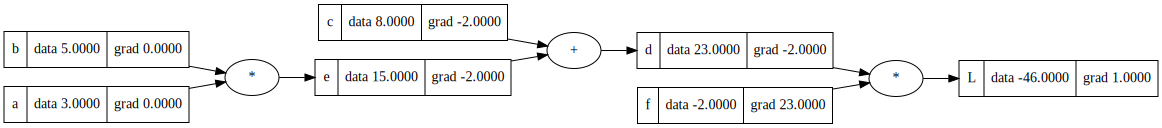

In [16]:
c.grad = -2.0
e.grad = -2.0
draw_dot(L)

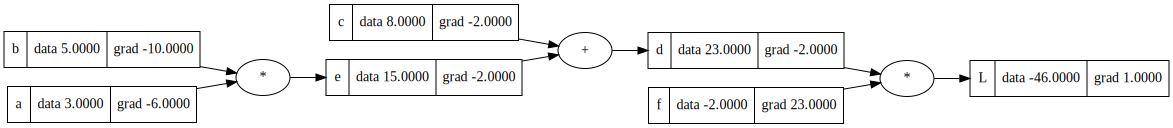

In [17]:
# similarily for a , b

a.grad = 3.0 * -2.0
b.grad = 5.0 * -2.0
draw_dot(L)

### Demonstration of simple optimization fo the NN

#### To adjust the value of L (Loss function)

We have the control over all the leaf nodes,

which are a, b, c and f

by simply updating the value of of these nodes by a small step

using gradient we know how much the value will affect our final outcome/Loss function

so by simply multiplying a small value (0.01) with the node's gradient, it is definitely going to impact the loss function, the way we intent to.
either reduce or increase (numerically for this case)

In [19]:

## Optimizing Loss function value

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = a+c
L = d*f
print(L.data)

-19.009800000000002
